# Data Preparation Stage: Object Detection using Amazon SageMaker Processing and Tensor Flow

## Overview
Here we build a custom SageMaker Processing job with our own processing container. We first build a Docker container with the necessary TensorFlow image, Python libraries, and code to run those steps and push it to an Amazon Elastic Container Registry (Amazon ECR) repository. We then launch a processing job, which runs the pushed container and prepares the data for training. 

### What are tfrecords?
The TFRecord format is a simple format for storing a sequence of binary records, which helps in data reading and processing efficiency. https://www.tensorflow.org/tutorials/load_data/tfrecord

### Why do we need tfrecords?
To use our dataset in the TensorFlow Object Detection API, we must first combine its images and labels and convert them into the TFRecord file format. We also need to generate a label map, which defines the mapping between a class ID and a class name.

### What is Amazon Sagemaker processing job?
An Amazon SageMaker processing job is used to analyze data and evaluate models. With Processing, you can use a simplified, managed experience on SageMaker to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. You can also use the Amazon SageMaker Processing APIs during the experimentation phase and after the code is deployed in production to evaluate performance.

## Prerequisites
1. Please ensure IAM role of jupyter notebook has below permissions:
AmazonSageMakerFullAccess
AmazonS3FullAccess
##Note:- Here we are using above permissions for demo purpose. In case of production setup, please setup granular IAM permissions based on least privilege model.
2. Please create a new prefix or folder in your existing or new s3 bucket (example: "car-gt-100",Refer to S3 bucket "name" created in your previous jupyter notebook.
3. Please upload the car image zip file (created in previous notebook)from local to S3. Note s3 url for zip file.
Example: https://<<"your_bucket_name">>.s3.<<"your_region">>.amazonaws.com>>/car-gt-100/car-100.zip
4. Please get the ground truth labeling job name from previous notebook. Example 'car-70'
5. Please replace code parameter <<'your_ground_truth_Job_name'>> at line number 31 =>
Code path => //<<'your_notebook'>>/<<'prefix'>>/1_prepare_data/docker/code/utils/tf_record_util.py

## Setup environment

In [ ]:
# Please ensure below libraries are available within your python environement.
# Uncomment the following lines to install the libraries
!pip install -q --upgrade pip
!pip install -q sagemaker==2.16.2
!pip install -q jsonlines

# Download dataset_util file from TF2 Object Detection GitHub repository
!wget -P ./docker/code/utils https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/dataset_util.py

## Import below libraries

In [ ]:
import os
import boto3
import jsonlines
import sagemaker
import numpy as np
from PIL import Image
from itertools import cycle, islice
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

sagemaker_session = sagemaker.Session()

# Using jupyter notebook instance role for training in this example, ensure IAM role has permission to Sagemaker, S3 & ECR.
role = sagemaker.get_execution_role() 

# you can specify a custom S3 bucket name here, we're using the default bucket of SageMaker
bucket = sagemaker_session.default_bucket() 

<a name="introduction"></a>
## Get data
Refer Step-3, where we placed the labelled dataset in S3 in a single zip archive as: https://<<"your_bucket_name">>.s3.<<"your_region">>.amazonaws.com>>/car-gt-100/car-100.zip

Please generate & copy the presigned URL of the S3 zip file as shown below:-
Go to S3 bukcet => select the zip file "car-100.zip" => click "Actions" => click "Download as" => Right click the zip file & copy the link address URL (which is called a presigned URL and only valid for 15 mins by default.)

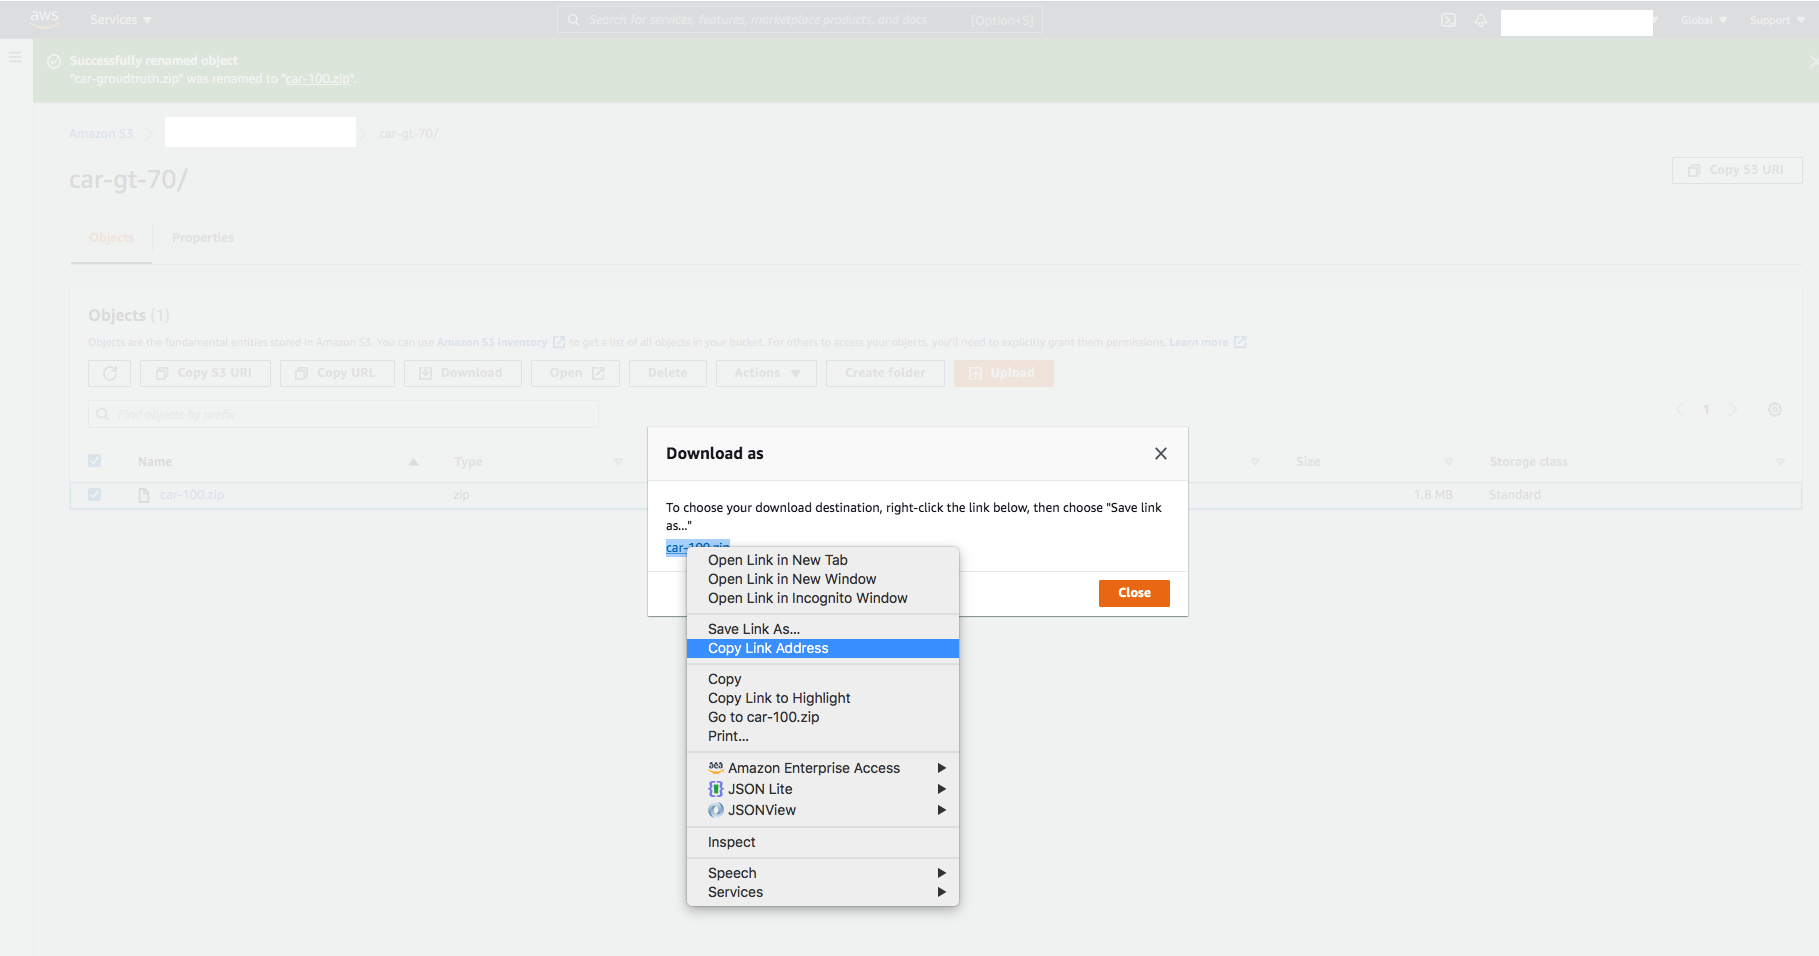

Here is the Zip file "S3 presigned URL" => https://<<"your_bucket_name">>.s3.<<"your_region">>.amazonaws.com/car-gt-70/car-100.zip?response-content-disposition=attachment&X-Amz-Security-Token=<<"your_unique_temporary_token">>

In [ ]:
!wget -O /tmp/car.zip "https://<<"your_bucket_name">>.s3.<<"your_region">>.amazonaws.com/car-gt-70/car-100.zip?response-content-disposition=attachment&X-Amz-Security-Token=<<"your_unique_temporary_token">>"
!mkdir data
!unzip -qo /tmp/car.zip -d data

The archive contains the following structure: 
- Number of `.jpg` image files of damage cars showing "dent" and/or "scratch"
- A "output.manifest" file 

Now let's upload this dataset to your Sagemaker S3 bucket for data preperation, transformation and training using Amazon SageMaker.

In [ ]:
prefix = 'data/car-gt-100/raw'
s3_input = sagemaker_session.upload_data('data', bucket, prefix)
print(s3_input)

## Visualize labelled images

Let's define a function that displays the local image file and draws over it the bounding boxes obtained via sagemaker ground truth labeling.

In [ ]:
def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['w', 'g', 'b', 'y', 'c', 'm', 'k', 'r'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=2,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

##### Next, read the augmented manifest (JSON lines format) line by line and display the first 15 images.

In [ ]:
labeling_job_name = 'car-70' # <<'ground truth labeling job name'>>, refer previous notebook.
augmented_manifest_file = 'data/car-groudtruth/output.manifest' # Local Path of your images & manifest file copied via wget in above steps. 

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 15):
        img_url = desc['source-ref']
        img_file = f'data/car-groudtruth/{os.path.basename(img_url)}'
        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

Lets process the object detection labels output from Ground Truth (via output manifest file) and generate TFrecords files to be used during the model training

## Build and push container image

Lets use the bring your own (BYO)* concepts of sagemaker by using your custom model & container image with SageMaker. First step is to build a docker container (enabling you to chose the base docker image and custom libraries to be installed) and push the docker to Amazon ECR so it's accessible by Amazon SageMaker 

In [ ]:
image_name = 'tfrecord-processing-car-1'

In [ ]:
#The following command takes a few minutes to complete
!sh ./docker/build_and_push.sh $image_name

In [ ]:
# Get the ECR image uri
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]
    
print(container)

## Launch Amazon SageMaker processing job to generate TFrecords

In [ ]:
data_processor = Processor(role=role, 
                           image_uri=container, 
                           instance_count=1, 
                           instance_type='ml.m5.xlarge',
                           volume_size_in_gb=30, 
                           max_runtime_in_seconds=1200,
                           base_job_name='tf2-object-detection')

In [ ]:
input_folder = '/opt/ml/processing/input'
ground_truth_manifest = '/opt/ml/processing/input/output.manifest'
label_map = '{"0": "dent","1": "scratch"}' # class mapping here - e.g. - each class ID should map to the human readable equivalent
# Verify your groundtruth output.manifest file and capture all unique class-map values like "0": "dent", "1" : scratch. 
# Use them as label map attributes above.
output_folder = '/opt/ml/processing/output'

data_processor.run(
    arguments= [
        f'--input={input_folder}',
        f'--ground_truth_manifest={ground_truth_manifest}',
        f'--label_map={label_map}',
        f'--output={output_folder}'
    ],
    inputs = [
        ProcessingInput(
            input_name='input',
            source=s3_input,
            destination=input_folder
        )
    ],
    outputs= [
        ProcessingOutput(
            output_name='tfrecords',
            source=output_folder,
            destination=f's3://{bucket}/data/car-gt-100/tfrecords'
        )
    ]
)

In [ ]:
print(s3_input)